In [42]:
# MobileNetV2를 전이학습(미세조정)하여 꽃(클래스 5가지) 분류 모델 작성
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [43]:
(train_ds, val_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,     # 관련 정보 보기
    as_supervised=True,     # True : tuple type으로 반환 , False : dict type으로 반환
    shuffle_files=True    # shuffle_file은 기본. 무작위로 섞어라
)

print(train_ds)
print(val_ds)
# print(ds_info)

total = ds_info.splits['train'].num_examples
print("train 원본(전체) 개수 : ", total)
print("train_ds 개수 : ", int(total * 0.8))
print("val_ds 개수 : ", int(total * 0.1))

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
train 원본(전체) 개수 :  3670
train_ds 개수 :  2936
val_ds 개수 :  367


원본 1장 :  (240, 182, 3) 1
dandelion
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


2025-09-25 10:56:53.044336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


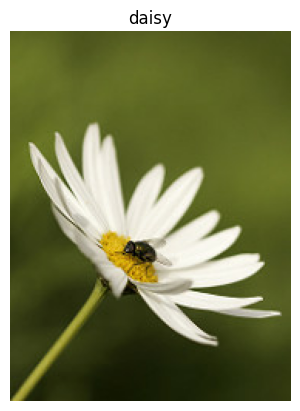

2025-09-25 10:56:53.100823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [44]:
# 불러온 이미지 시각화

# 샘플 크기 확인
for image, label in train_ds.take(1):
    print('원본 1장 : ', image.shape, label.numpy()) # (262, 350, 3) 1
    
# 레이블 확인
get_label_name = ds_info.features['label'].int2str
print(get_label_name(0))    # 하나만 꺼내서 보는 방식
print(ds_info.features['label'].names)    # ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


for image, label in train_ds.take(1):
    plt.figure()
    plt.imshow(image)
    plt.title(f"{get_label_name(label)}")
    plt.axis('off')   
    plt.show()
    plt.close()

In [45]:
# 전처리
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)   # MobileNetV2가 원하는 사이즈로 변경
    image = tf.cast(image, tf.float32) / 255.0    # 정규화 Normalization ; 실수화 작업하면 모델이 안정적으로 학습한다
    return image, label

train_ds = train_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)     # BATCH_SIZE대로 읽어라
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 사전 학습된 모델 BackBone 불러오기
base_model = tf.keras.applications.MobileNetV2(
    input_shape = IMG_SIZE + (3, ),     # (160, 160) -> (160, 160 ,3)
    include_top = False,     # MobileNetV2의 분류기 Dense는 사용하지 않고, 이미지 특징 추출기만 가져오는 옵션이다.
    weights = 'imagenet'    # 사전 학습된 가중치 불러와서 초기화 옵션이다. None은 무작위 초기화 옵션이다.
)

base_model.trainable = False    # 이미지 특징 추출기 학습에 참여시키지마

# 모델 생성
model = tf.keras.Sequential([
    base_model,    # MobileNetV2의 Conv와 가중치 역할만 사용
    tf.keras.layers.GlobalAveragePooling2D(),     # 특징맵 feature map 평탄화
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax')    # ds_info.features['label'].num_classes = 5
])

# model.summary()

# 모델 학습
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_ds, epochs=3, batch_size=BATCH_SIZE, validation_data=val_ds)

# 평가
loss, acc = model.evaluate(val_ds, verbose=0)
print(f"최종 분류 정확도 : {acc:.4f}")
print(f"loss : {loss:.4f}")

# 최종 분류 정확도 : 0.8937
# loss : 0.3548
# 결과가 만족스럽지 않다면 미세조정 Fine Tuning해준다.

Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.7514 - loss: 0.7683 - val_accuracy: 0.8542 - val_loss: 0.3881
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.8515 - loss: 0.4470 - val_accuracy: 0.8760 - val_loss: 0.3469
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.8818 - loss: 0.3378 - val_accuracy: 0.8828 - val_loss: 0.3610
최종 분류 정확도 : 0.8828
loss : 0.3610


In [49]:
# 미세조정 Fine Tuning
# 전이학습 후 성능을 좀 더 향상시키고자 할 때 실시한다.

base_model.trainable = True

print(f"total layers : {len(base_model.layers)}")

'''
for i, layer in enumerate(base_model.layers):
    if layer.trainable:
        print(f"[{i}] {layer.name}")

# 핵심 레이어가 있고, 아닌 레이어도 있다.
# 핵심 레이어: Conv, DepthwiseConv, PointwiseConv(Project/Expand), Residual Add
# 노이즈(보조) 레이어: BatchNorm, ReLU, Padding
'''

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 미세 조정 후 모델 재학습
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.fit(train_ds, epochs=3, batch_size=BATCH_SIZE, validation_data=val_ds, verbose=1)

# 미세조정 평가
loss, acc = model.evaluate(val_ds, verbose=0)
print(f"미세조정 후 분류 정확도 : {acc:.4f}")
print(f"loss : {loss:.4f}")

total layers : 154
Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 382ms/step - accuracy: 0.8031 - loss: 0.5762 - val_accuracy: 0.8828 - val_loss: 0.3491
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 362ms/step - accuracy: 0.8569 - loss: 0.4101 - val_accuracy: 0.8842 - val_loss: 0.3454
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 362ms/step - accuracy: 0.8910 - loss: 0.3039 - val_accuracy: 0.8842 - val_loss: 0.3405
미세조정 후 분류 정확도 : 0.8842
loss : 0.3405


In [53]:
# 예측
for image, label in val_ds.take(1):
    sample_images = image
    sample_labels = label
    break

pred_probs = model.predict(sample_images)
# print(f"pred_probs : {pred_probs}")    # 확률값

pred_classes = tf.argmax(pred_probs, axis=1)    # argmax : 어떤 축(axis)에서 최댓값의 인덱스를 반환하는 함수
print(f"pred_classes : {pred_classes}")    # 행별로 확률값 중 가장 큰 값의 인덱스 출력 

class_names = ds_info.features['label'].names
print(f"class_names : {class_names}")

# 에측 인덱스 vs 실제 인덱스 출력 코드
for i in range(len(sample_images)):
    # 인덱스
    predicted_index = int(pred_classes[i])
    actual_index = int(sample_labels[i])
    
    # 클래스 명
    predicted_name =class_names[predicted_index]
    actual_name = class_names[actual_index]
    
    print(f"[{i:02}] Predicted:{predicted_index}({predicted_name})\
    | Actual:{actual_index}({actual_name})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
pred_classes : [4 2 2 2 1 1 1 2 3 3 4 3 3 2 2 0 2 0 3 0 2 4 4 2 3 0 2 1 0 4 0 3]
class_names : ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
[00] Predicted:4(roses)    | Actual:4(roses)
[01] Predicted:2(tulips)    | Actual:2(tulips)
[02] Predicted:2(tulips)    | Actual:2(tulips)
[03] Predicted:2(tulips)    | Actual:2(tulips)
[04] Predicted:1(daisy)    | Actual:1(daisy)
[05] Predicted:1(daisy)    | Actual:1(daisy)
[06] Predicted:1(daisy)    | Actual:1(daisy)
[07] Predicted:2(tulips)    | Actual:2(tulips)
[08] Predicted:3(sunflowers)    | Actual:3(sunflowers)
[09] Predicted:3(sunflowers)    | Actual:3(sunflowers)
[10] Predicted:4(roses)    | Actual:4(roses)
[11] Predicted:3(sunflowers)    | Actual:3(sunflowers)
[12] Predicted:3(sunflowers)    | Actual:3(sunflowers)
[13] Predicted:2(tulips)    | Actual:2(tulips)
[14] Predicted:2(tulips)    | Actual:2(tulips)
[15] Predicted:0(dandelion)    | Actual:0(dandelion)
[16] Predicted:2(tulips)    | 

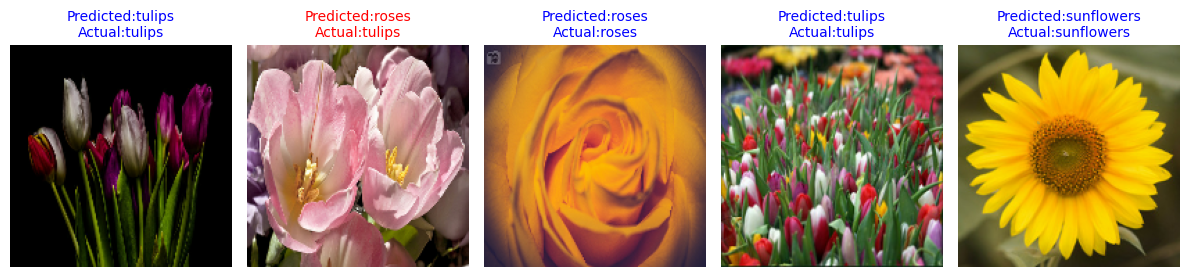

In [57]:
# 예측 결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
a = 1
for i in range(20,25):
    plt.subplot(1, 5, a)
    plt.imshow(sample_images[i])
    a += 1
    predicted_label = class_names[pred_classes[i]]
    actual_label = class_names[sample_labels[i]]
    color = 'blue' if predicted_label==actual_label else 'red'
    
    plt.title(f"Predicted:{predicted_label}\nActual:{actual_label}", color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()    
plt.show()
plt.close()    